#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [157]:
import sys

sys.path.append(
    "../../ex02/template"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [158]:
#import grid_search  # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
#from grid_search import *  # You can call any functions of the file with function_name()
import gradient_descent as gd

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [159]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [204]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """

    w_opt   = np.linalg.solve(tx.T@tx, tx.T@y)
    mse     = (1/2)*np.mean((y - tx@w_opt)**2)

    return (w_opt, mse)

### You can test your implementation here

In [205]:
test(least_squares)
# NB:
#
# Due to precision issues,
# the output might not be exactly the same
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:)

❌ The are some issues with your implementation of `least_squares`:
**********************************************************************
File "__main__", line 13, in least_squares
Failed example:
    least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
Expected:
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
Got:
    (array([ 0.21212121, -0.12121212]), 2.946672814912471e-32)
**********************************************************************


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [206]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    least_square_w, least_square_mse = least_squares(y, tx)
    grid_search_w, grid_search_mse = compute_grid_search(y, tx)
    gradient_descent_mse, gradient_descent_w = gd.gradient_descent(y, tx, initial_w=np.array([0, 0]), max_iters=100, gamma=0.5)
    gradient_descent_w, gradient_descent_mse = gradient_descent_w[-1], gradient_descent_mse[-1]
    print(f"grid_search:    {grid_search_w}")
    print(f"gradient_descent:  {gradient_descent_w}")
    print(f"least_squares:  {least_square_w}")
    

    return np.linalg.norm(least_square_w - gradient_descent_w) 
    

Test it here

In [207]:
test_your_least_squares()

GD iter. 0/99: loss=2792.2367127591674, w0=36.64696100105258, w1=6.739856217494479
GD iter. 1/99: loss=709.5985940914146, w0=54.97044150157889, w1=10.109784326241748
GD iter. 2/99: loss=188.9390644244757, w0=64.13218175184204, w1=11.794748380615385
GD iter. 3/99: loss=58.774182007740976, w0=68.71305187697361, w1=12.637230407802212
GD iter. 4/99: loss=26.232961403557326, w0=71.0034869395394, w1=13.058471421395627
GD iter. 5/99: loss=18.09765625251138, w0=72.1487044708223, w1=13.269091928192337
GD iter. 6/99: loss=16.0638299647499, w0=72.72131323646374, w1=13.374402181590693
GD iter. 7/99: loss=15.55537339280952, w0=73.00761761928446, w1=13.42705730828987
GD iter. 8/99: loss=15.428259249824434, w0=73.15076981069483, w1=13.453384871639459
GD iter. 9/99: loss=15.396480714078157, w0=73.22234590640001, w1=13.466548653314254
GD iter. 10/99: loss=15.38853608014159, w0=73.2581339542526, w1=13.473130544151651
GD iter. 11/99: loss=15.386549921657448, w0=73.27602797817889, w1=13.47642148957035
GD 

2.4868995751603507e-14

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [208]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [209]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    phi = np.ones((len(x),degree+1))
    for i in range(1,degree+1):
        phi[:,i] = x.T**i
    
    return phi

In [210]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [216]:
from plots import *


def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
    and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)
    
    for ind, degree in enumerate(degrees):
        phi = build_poly(x, degree)

        weights = least_squares(y, phi)[0]

        rmse = np.sqrt(np.mean(y - phi@weights))

        print(
            "Processing {i}th experiment, degree={d}, rmse={loss}".format(
                i=ind + 1, d=degree, loss=rmse
            )
        )
        # plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

C:\Users\antho\AppData\Local\Temp\ipykernel_14644\956203626.py:20: RuntimeWarning: invalid value encountered in sqrt
  rmse = np.sqrt(np.mean(y - phi@weights))


Processing 1th experiment, degree=1, rmse=nan
Processing 2th experiment, degree=3, rmse=3.0048109337800416e-08
Processing 3th experiment, degree=7, rmse=nan
Processing 4th experiment, degree=12, rmse=nan


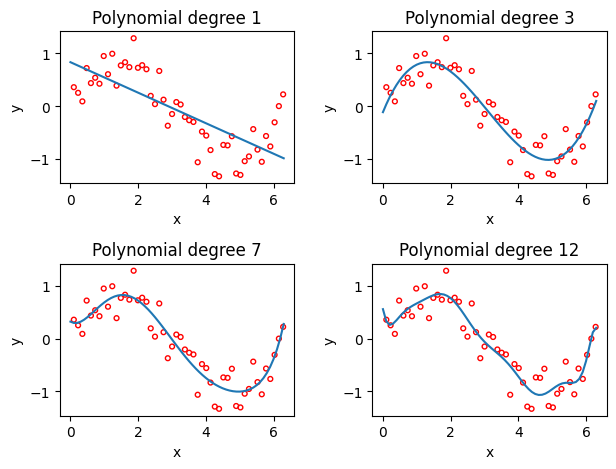

In [217]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [227]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    indices = np.random.permutation(x.shape[0])
    training_idx, test_idx = indices[:int(ratio*x.shape[0])], indices[int(ratio*x.shape[0]):]

    x_training, x_test = x[training_idx], x[test_idx]
    y_training, y_test = y[training_idx], y[test_idx]

    return x_training, x_test, y_training, y_test

In [228]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [229]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed=seed)

    phi_tr = build_poly(x_tr, degree)
    phi_te = build_poly(x_te, degree)
    
    weights = least_squares(y_tr, phi_tr)[0]
    
    rmse_tr  = np.sqrt(np.mean(y_tr - phi_tr@weights))
    rmse_te   = np.sqrt(np.mean(y_te - phi_te@weights))

    print(
        "proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, tr=rmse_tr, te=rmse_te
        )
    )

    return x_tr, x_te, y_tr, y_te, weights

Demo time

C:\Users\antho\AppData\Local\Temp\ipykernel_14644\1176832662.py:19: RuntimeWarning: invalid value encountered in sqrt
  rmse_te   = np.sqrt(np.mean(y_te - phi_te@weights))
C:\Users\antho\AppData\Local\Temp\ipykernel_14644\1176832662.py:18: RuntimeWarning: invalid value encountered in sqrt
  rmse_tr  = np.sqrt(np.mean(y_tr - phi_tr@weights))


proportion=0.9, degree=1, Training RMSE=0.000, Testing RMSE=nan
proportion=0.9, degree=3, Training RMSE=nan, Testing RMSE=nan
proportion=0.9, degree=7, Training RMSE=0.000, Testing RMSE=nan
proportion=0.9, degree=12, Training RMSE=0.000, Testing RMSE=nan
proportion=0.7, degree=1, Training RMSE=nan, Testing RMSE=nan
proportion=0.7, degree=3, Training RMSE=0.000, Testing RMSE=0.261
proportion=0.7, degree=7, Training RMSE=nan, Testing RMSE=0.291
proportion=0.7, degree=12, Training RMSE=0.000, Testing RMSE=0.284
proportion=0.5, degree=1, Training RMSE=nan, Testing RMSE=0.293
proportion=0.5, degree=3, Training RMSE=0.000, Testing RMSE=0.123
proportion=0.5, degree=7, Training RMSE=nan, Testing RMSE=0.092
proportion=0.5, degree=12, Training RMSE=0.000, Testing RMSE=0.574
proportion=0.1, degree=1, Training RMSE=nan, Testing RMSE=0.487
proportion=0.1, degree=3, Training RMSE=nan, Testing RMSE=nan
proportion=0.1, degree=7, Training RMSE=nan, Testing RMSE=0.405
proportion=0.1, degree=12, Training

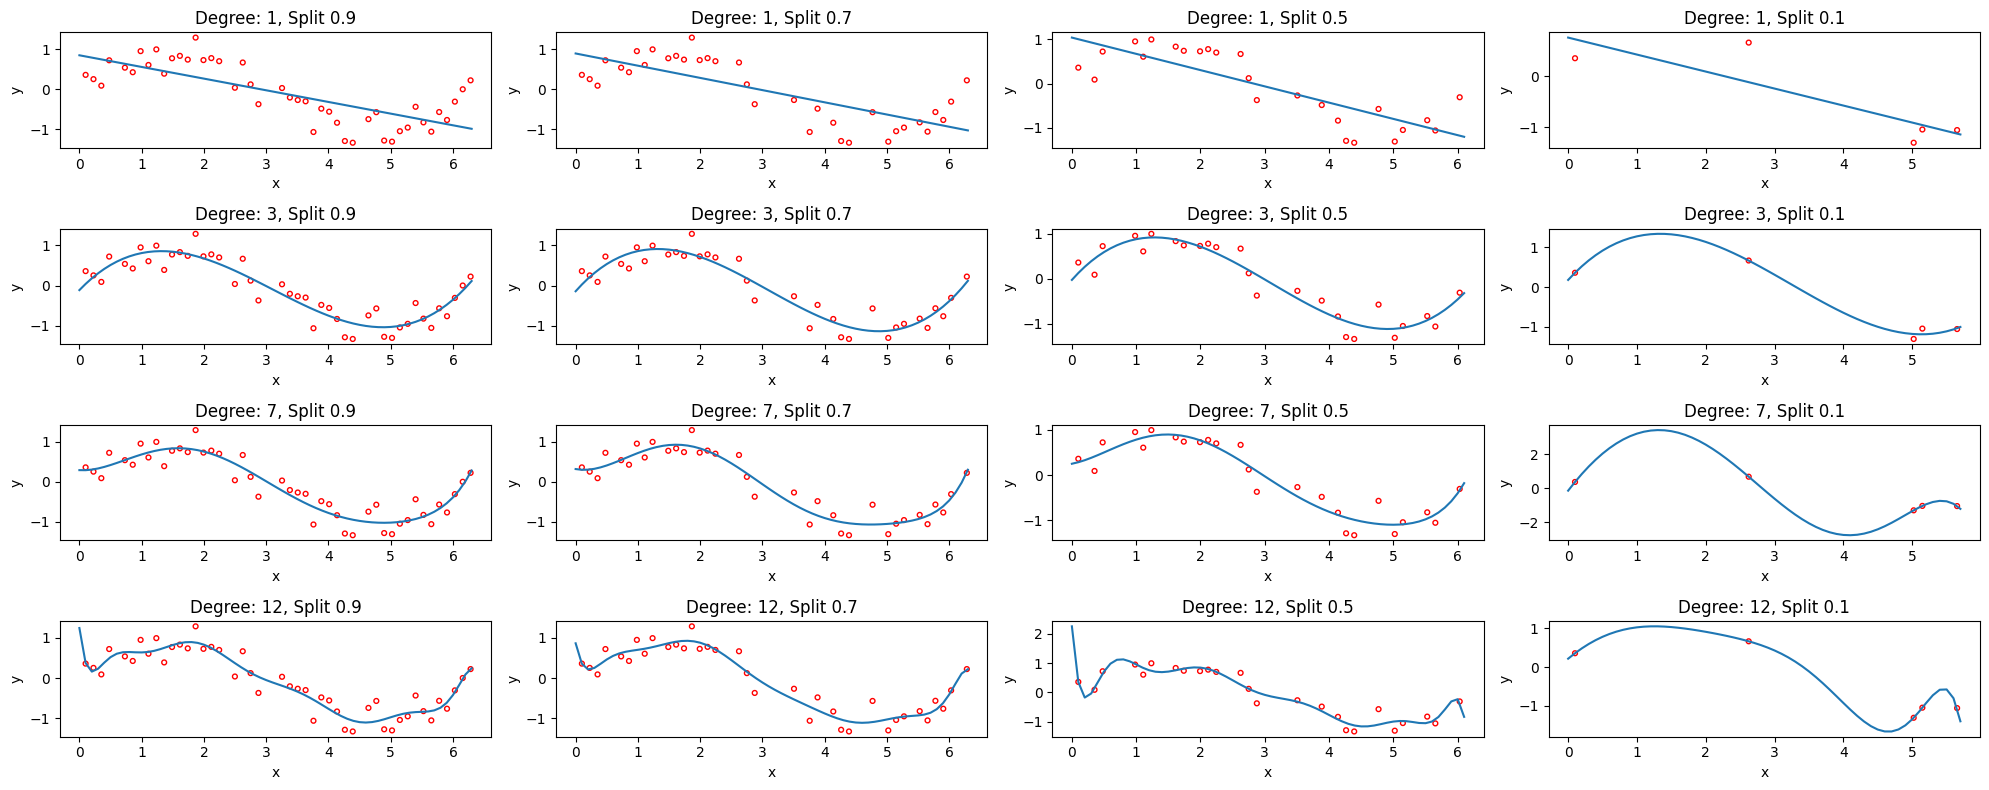

In [230]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [310]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    N = len(y)
    w_opt   = np.linalg.solve((tx.T@tx + 2*N*lambda_*np.eye(tx.shape[1])), tx.T@y)
    rmse     = np.sqrt(np.mean((y - tx@w_opt)**2))
    
    return w_opt

In [311]:
test(ridge_regression)

✅ Your `ridge_regression` passed 2 tests.


In [314]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed=seed)
    
    phi_tr = build_poly(x_tr, degree)
    phi_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        weights = ridge_regression(y_tr, phi_tr, lambda_)

        rmse_tr.append(np.sqrt(np.mean(y_tr - phi_tr@weights)))
        rmse_te.append(np.sqrt(np.mean(y_te - phi_te@weights)))

        print(
            "proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]
            )
        )
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

C:\Users\antho\AppData\Local\Temp\ipykernel_14644\3510355999.py:17: RuntimeWarning: invalid value encountered in sqrt
  rmse_te.append(np.sqrt(np.mean(y_te - phi_te@weights)))


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.002, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.003, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.005, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.009, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.015, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.024, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.038, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.058, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.084, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.116, Testing RMSE=nan
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.153, Testing RMSE=0.197
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.192, Testing RMSE=0.324
proportion=0.5, degree=7, lambda=0.193, Training RMSE=0.227,

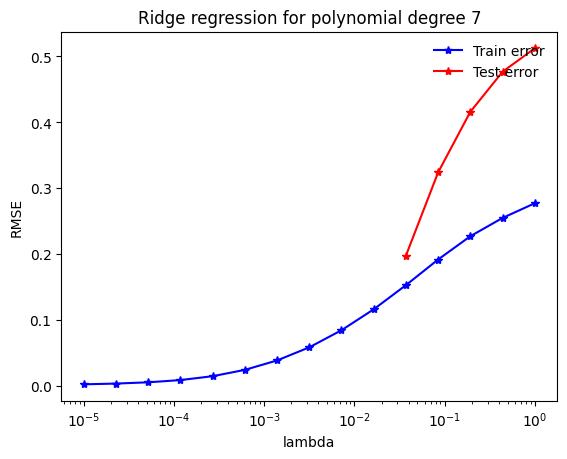

In [315]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)